In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [ ]:
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [ ]:
X_train.shape

(60000, 28, 28)

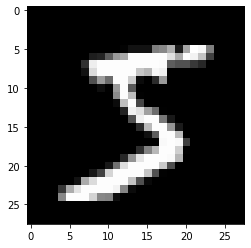

In [ ]:
image = X_train[0]
plt.imshow(image, 'gray')
plt.show()

In [ ]:
image.shape

(28, 28)

In [ ]:
# 실제 텐서플로우의 CNN은 4차원으로 데이터를 받는다.
# 차원 확장
image = image[tf.newaxis, ..., tf.newaxis]
image.shape

(1, 28, 28, 1)

# CNN

## Convolusion 레이어의 하이퍼 파라미터
* filters : 필터의 개수
    * 필터의 개수가 많다는 이야기는 뉴런의 개수를 결정짓는 말과 똑같다.
* kernel_size : 필터의 가로 세로 크기
    * 보통 3x3 ~ 5x5를 사용함.
* strides : 필터가 몇개의 픽셀을 스킵하면서 지나갈 것인지
* padding : VALID패딩 -> 패딩 있음 / SAME패딩 -> 패딩 없음
* activation : 활성화 함수 사용하기, 나중에 레이어로 추가 가능

In [ ]:
tf.keras.layers.Conv2D(filters=3, kernel_size=(3, 3), strides=(1, 1), padding='SAME', activation='relu')

In [ ]:
# 파라미터가 정사각형이라면 튜플로 지정 안해도 됨.
tf.keras.layers.Conv2D(filters=3, kernel_size=3, strides=1, padding='SAME', activation='relu')

In [ ]:
image = tf.cast(image, dtype=tf.float32)
image.shape

TensorShape([1, 28, 28, 1])

In [ ]:
layer = tf.keras.layers.Conv2D(filters=5, kernel_size=(3, 3), strides=(1, 1), padding='SAME')
layer

In [ ]:
output = layer(image)
output.shape

TensorShape([1, 28, 28, 5])

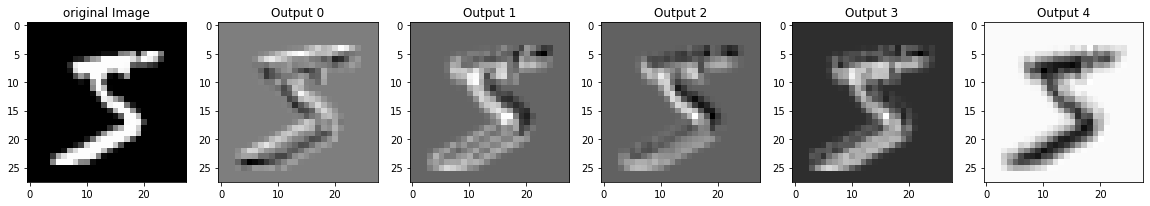

In [ ]:
_, axes = plt.subplots(nrows=1, ncols=6, figsize=(20, 10))

axes[0].imshow(image[0, ..., 0], cmap='gray')
axes[0].set_title("original Image")
for idx, ax in enumerate(axes[1:]):
    ax.set_title("Output {}".format(idx))
    ax.imshow(output[0, ..., idx], cmap='gray')
plt.show()

## Filter 확인하기

In [ ]:
# 0번에는 가중치 1번에는 편향
weights = layer.get_weights()
weights[0].shape, weights[1].shape

((3, 3, 1, 5), (5,))

(필터의 세로크기 필터의 가로크기, 채널수, 필터의 개수)

## 필터 시각화

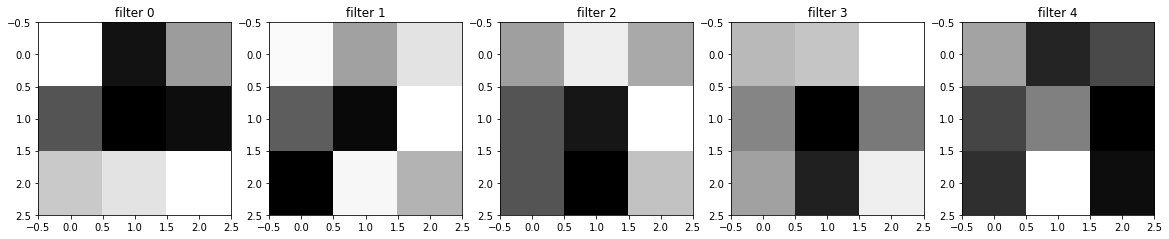

In [ ]:
_, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 10))

for idx, ax in enumerate(axes):
    ax.set_title("filter {}".format(idx))
    ax.imshow(weights[0][:, :, 0, idx], 'gray')
plt.show()


## ReLU 레이어 적용하기

In [ ]:
output.shape

TensorShape([1, 28, 28, 5])

In [ ]:
np.min(output), np.max(output)

(-313.1986, 212.78586)

In [ ]:
act_layer = tf.keras.layers.ReLU()
act_output = act_layer(output)
act_output.shape

TensorShape([1, 28, 28, 5])

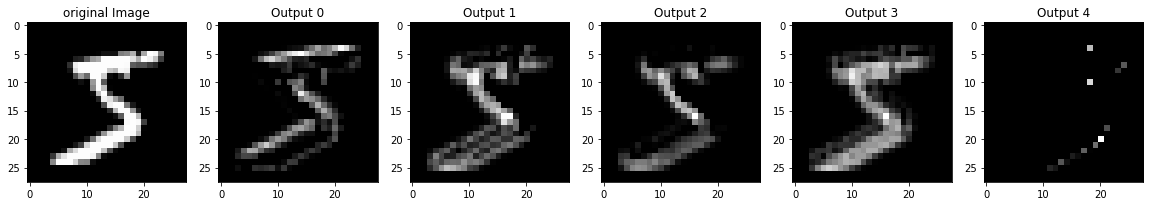

In [ ]:
_, axes = plt.subplots(nrows=1, ncols=6, figsize=(20, 10))

axes[0].imshow(image[0, ..., 0], cmap='gray')
axes[0].set_title("original Image")
for idx, ax in enumerate(axes[1:]):
    ax.set_title("Output {}".format(idx))
    ax.imshow(act_output[0, ..., idx], cmap='gray')
plt.show()

## MaxPooling 레이어
- 약간 움직여도 같은 이미지임을 찾아준다.

In [ ]:
pool_layer = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='SAME')
pool_output = pool_layer(act_output)
pool_output.shape

TensorShape([1, 14, 14, 5])

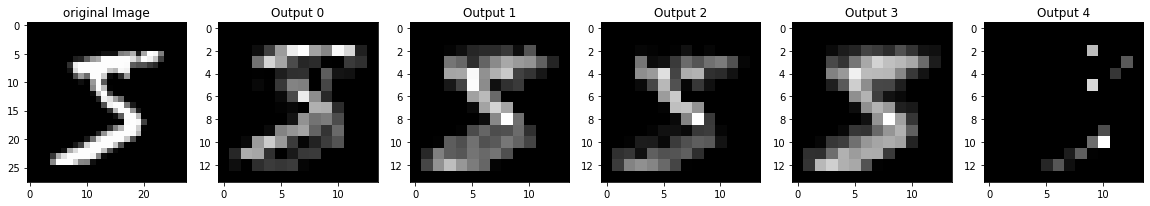

In [ ]:
_, axes = plt.subplots(nrows=1, ncols=6, figsize=(20, 10))

axes[0].imshow(image[0, ..., 0], cmap='gray')
axes[0].set_title("original Image")
for idx, ax in enumerate(axes[1:]):
    ax.set_title("Output {}".format(idx))
    ax.imshow(pool_output[0, ..., idx], cmap='gray')
plt.show()

## flatten Layer

In [ ]:
flatten_layer = tf.keras.layers.Flatten() 
flatten_output = flatten_layer(pool_output)
flatten_output.shape

TensorShape([1, 980])

## Dense 레이어
- Affine 레이어
- 행렬 내적 연산

In [ ]:
dense_layer = tf.keras.layers.Dense(32, activation='relu')
dense_output = dense_layer(flatten_output)
dense_output.shape
# 한장의 이미지가 들어와서 32개의 출력을 낼 것.

TensorShape([1, 32])

In [ ]:
dense_layer2 = tf.keras.layers.Dense(10, activation='relu')
dense_output2 = dense_layer2(dense_output)
dense_output2.shape

TensorShape([1, 10])

## 초간단 CNN레이어 연결하기
* 사용할 데이터의 feature 형상 지정 -> input_shape
    * 28, 28, 1
* 분류할 데이터 개수 미리 지정 -> num_classes
    * 데이터가 10개 들어갈 것임.

In [ ]:
from tensorflow.keras import layers

input_shape = (28, 28, 1)
num_classes = 10

In [ ]:
# 1. 텐서 플로우를 활용한 신경망의 시작은 InputLayer로 시작한다.
inputs = layers.Input(shape=input_shape)

# 2. CNN 레이어 구축 -> Feature Extraction
# strides를 입력하지 않으면 기본적으로 1이 할당됨.
net = layers.Conv2D(32, 3, padding='SAME')(inputs)
net = layers.Activation('relu')(net)
net = layers.Conv2D(32, 3, padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPool2D((2, 2))(net)

# 과적합 방지를 위해서 dropout
# Dropout(0.25) 25%의 데이터를 drop -> 0으로 만들어 버리겠다.
net = layers.Dropout(0.25)(net)


net = layers.Conv2D(64, 3, padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.Conv2D(64, 3, padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPool2D((2, 2))(net)
net = layers.Dropout(0.25)(net)


# 3. Dense Layer를 활용 -> Fully Connected
net = layers.Flatten()(net)
# z를 구하는 구간.
net = layers.Dense(512)(net)
net = layers.Activation('relu')(net)
net = layers.Dropout(0.25)(net)

# 출력층 설계
net = layers.Dense(num_classes)(net)
net = layers.Activation('softmax')(net)

model = tf.keras.Model(inputs=inputs, outputs=net, name='Basic_CNN')

In [ ]:
model.summary()

Model: "Basic_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
activation_18 (Activation)   (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
activation_19 (Activation)   (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 14, 14, 32)        0 

## 모델을 평가할 수 있는 최적화 함수 선정
- Loss Function(MSE, CEE)
- Optimization(SGD, ADAM, RMSPROPS, lbfgs, Momentum 등등....
- Metrics(평가 기준) - 정확도로 많이 함

### Loss Function 선정하기
- MSE는 회귀문제
- CEE는 다중분류

- Binary classification( 이진 분류시에 많이 사용 )
- Categorical Classification( 이진 분류 이상에서 광범위하게 사용 )

In [ ]:
# 이진 분류를 위한 CEE
loss = 'binary_crossentropy'

# 다중 분류를 위한 CEE
loss = 'categorical_crossentropy'

#### categorical CEE / sparse categorical CEE

- categorical_crossentropy : 원핫 인코딩 된 레이블에 사용 (예전에 해본적있음)
- sparse_categorical_crossentropy : 원핫 인코딩이 안된 레이블에 사용

In [ ]:
y_train[:5]

array([5, 0, 4, 1, 9], dtype=uint8)

In [ ]:
# 케라스에서 각종 손실함수 불러오기
loss_func = tf.keras.losses.sparse_categorical_crossentropy
loss_func

<function tensorflow.python.keras.losses.sparse_categorical_crossentropy>

### Metric (평가기준)
- accuracy(정확도 확인)

In [ ]:
metrics = ['accuracy'] # 또는 [acc]

In [ ]:
tf.keras.metrics.Accuracy()

### Optimizer
- sgb (기본)
- rmsprop (adam이 잘 안되면 시도해 볼만함.)
- adam(거의 모든 상황에서 잘 작동함)
- lbfgs

In [ ]:
optm = tf.keras.optimizers.Adam()

### Model Compile
1. 레이어를 쌓아서 네트워크 준비
2. 손실, 평가, 최적화 준비하기
3. 모델 컴파일

In [ ]:
# 실제 빌드 과정
# 최적화 계획 손실 등 모두 완료된 상태
model.compile(optimizer=optm, loss=loss_func, metrics=metrics)

In [ ]:
X_train.shape

(60000, 28, 28)

In [ ]:
X_test.shape

(10000, 28, 28)

In [ ]:
X_train = X_train[..., tf.newaxis]
X_test = X_test[..., tf.newaxis]

In [ ]:
X_train.shape, X_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

### 스케일링 작업
- 실수를 넣어줘야하기 때문에 스케일링 같은 것을 한다.
- 안하면 훈련이 잘 안됨.
- 매우매우 권장됨.

In [ ]:
X_train_scaled = X_train / 255.0
X_test_scaled = X_test / 255.0

In [ ]:
np.min(X_train_scaled), np.max(X_train_scaled)

(0.0, 1.0)

In [ ]:
np.min(X_test_scaled), np.max(X_test_scaled)

(0.0, 1.0)

## 학습 시작
- 에폭
- 배치사이즈 설정하기

In [ ]:
num_epoche = 10
batch_size = 32

In [ ]:
model.fit(X_train_scaled, y_train, batch_size=batch_size, epochs=num_epoche, shuffle=True)

Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1292 - accuracy: 0.9607
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0507 - accuracy: 0.9845
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0374 - accuracy: 0.9883
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0312 - accuracy: 0.9903
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0254 - accuracy: 0.9923
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0232 - accuracy: 0.9933
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0212 - accuracy: 0.9934
Epoch 8/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0181 - accuracy: 0.9946
Epoch 9/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0185 - accuracy: 0.9944
Epoch 10/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.016

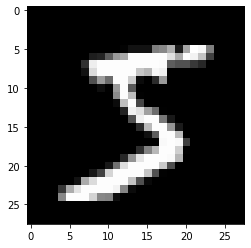

In [ ]:
plt.imshow(image[0, :, :, 0], 'gray')
plt.show()

In [ ]:
model.predict(image)

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

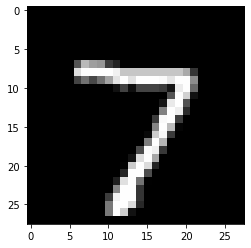

In [ ]:
image = X_test_scaled[0, :, :, 0]

plt.imshow(image, 'gray')
plt.show()

In [ ]:
y_test[0]

7

In [ ]:
image = image[tf.newaxis, ..., tf.newaxis] # 훈련할 때 4차원으로 훈련했으니까 테스트 할 때도 4차원으로 테스트
image.shape


(1, 28, 28, 1)

In [ ]:
predictions = model.predict(image)
predictions

array([[4.7198585e-11, 1.2495710e-09, 1.4689512e-10, 3.9125236e-09,
        3.8202316e-11, 1.1705649e-10, 4.7396237e-15, 9.9999988e-01,
        6.0092391e-12, 1.5728041e-07]], dtype=float32)

In [ ]:
np.argmax(predictions)

7

In [ ]:
for proba in predictions[0]:
    print("{:.10f}".format(proba))

0.0000000000
0.0000000012
0.0000000001
0.0000000039
0.0000000000
0.0000000001
0.0000000000
0.9999998808
0.0000000000
0.0000001573


In [ ]:
# tensorflow 원-핫 인코딩
tf.one_hot([0, 1, 2], 10)

<tf.Tensor: shape=(3, 10), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>